# OpenCv warpPerspective vs Tensorflow transform

To run the jupyter-notebook from inside a virtualenv, see:
- http://help.pythonanywhere.com/pages/IPythonNotebookVirtualenvs
- https://ipython.readthedocs.io/en/latest/install/kernel_install.html

## OpenCv

OpenCv [warpPerspective](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#warpperspective) takes 3×3 matrix

$$\left| \begin{matrix}
    a_1 & a_2 & a_3 \\
    b_1 & b_2 & b_3 \\
    c_1 & c_2 & c_3 \end{matrix} \right|$$

if WARP_INVERSE_MAP is set the mapping is computed as follows


$$dst(x,y) = src \left( \frac{a_1 x + a_2 y + a_3}{k}, \frac{b_1 x + b_2 y + b_3}{k}\right) $$

where $k = c_0 x + c_1 y + c_2$

## Tensorflow
[Tensorflow.contrib.image.transform](https://www.tensorflow.org/api_docs/python/tf/contrib/image/transform) expects matrix

$$\left| \begin{matrix}
    a_1 & a_2 & a_3 \\
    b_1 & b_2 & b_3 \\
    c_1 & c_2 &  \end{matrix} \right|$$

And the pixel in destination image is computed by

$$dst(x, y) = src\left( \frac{\left(a_0 x + a_1 y + a_2\right)}{k}, \frac{\left(b_0 x + b_1 y + b_2\right)}{k} \right)$$

where $k = c_1 x + c_2 y + 1$

Notice the given $1$ int the computation which requires the transform matrix has to be divided by its last element if it is not equal to $1$.



## Create a projection matrix

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

from __future__ import division

IMAGE="files/ps-doom.jpg"
FOV=30
ROT_VEC = np.deg2rad([70,0,0])

# Prepare parameters to construct elementary transformations
img = mpimg.imread(IMAGE)
#plt.imshow(img)
img_center = [dim // 2 for dim in img.shape[:2]]
distance = (img.shape[0] // 2) / np.tan(np.deg2rad(FOV // 2))

cos_rot_vec = np.cos(ROT_VEC)
sin_rot_vec = np.sin(ROT_VEC)

rows_id = np.asarray([0, 1, 3])
rows_id = rows_id[:, np.newaxis]

# Prepare matrices to construct final perspective matrix
identity = np.identity(4).reshape(4, 4)
translate = np.asarray([[1, 0, 0, -img_center[1]],
                        [0, 1, 0, -img_center[0]],
                        [0, 0, 1, 0],
                        [0, 0, 0, 1]])

rot_x = np.asarray([[1, 0, 0, 0],
                    [0, cos_rot_vec[0], -sin_rot_vec[0], 0],
                    [0, sin_rot_vec[0], cos_rot_vec[0], 0],
                    [0, 0, 0, 1]])

rot_y = np.asarray([[cos_rot_vec[1], 0, sin_rot_vec[1], 0],
                    [0, 1, 0, 0],
                    [-sin_rot_vec[1], 0, cos_rot_vec[1], 0],
                    [0, 0, 0, 1]])

rot_z = np.asarray([[cos_rot_vec[2], -sin_rot_vec[2], 0, 0],
                    [sin_rot_vec[2], cos_rot_vec[2], 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]])

rot = rot_z.dot(rot_y.dot(rot_x))

model = rot.dot(translate)

view = np.asarray([[1, 0, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, 1, distance],
                   [0, 0, 0, 1]])

# See http://kgeorge.github.io/2014/03/08/calculating-opengl-perspective-matrix-from-opencv-intrinsic-matrix
projection = np.asarray([[1, 0, img_center[1]/distance, 0],
                         [0, 1, img_center[0]/distance, 0],
                         [0, 0, 1, 0],
                         [0, 0, 1./distance, 0]])


p1 = projection.dot(view.dot(model))

mat = p1[rows_id, [0,1,3]]
mat /= mat[2,2]
print(mat)

[[  1.33652295e+00   3.36522952e-01  -4.30749379e+01]
 [  0.00000000e+00   7.93640724e-01   6.94889252e+01]
 [  0.00000000e+00   2.62908556e-03   1.00000000e+00]]


## OpenCv

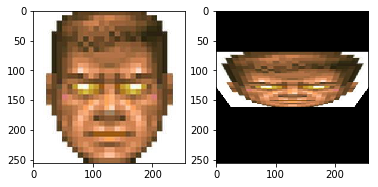

In [2]:
warped_image = cv2.warpPerspective(img,
                                   mat,
                                   (img.shape[1], img.shape[0]),
                                   borderMode=cv2.BORDER_CONSTANT,
                                   flags=cv2.INTER_AREA,
                                   borderValue=(0,0,0))
#plt.imshow(warped_image)

plt.subplot(1, 2, 1); plt.imshow(img)
plt.subplot(1, 2, 2); plt.imshow(warped_image)

## Tensorflow

Pinv matrix
[[  7.48210121e-01  -5.50820586e-01   7.05050350e+01]
 [  1.26819796e-16   1.63679946e+00  -1.13739435e+02]
 [ -1.15648914e-17  -4.30328583e-03   1.29903071e+00]]


Inv matrix scaled to have last element equal to 1
[[  5.75975700e-01  -4.24024300e-01   5.42751104e+01]
 [  9.76264804e-17   1.26001599e+00  -8.75571567e+01]
 [ -8.90270829e-18  -3.31268984e-03   1.00000000e+00]]


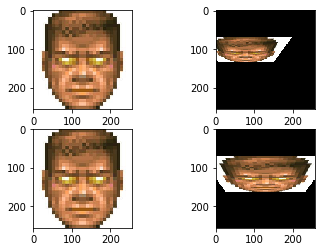

In [3]:
#Tensorflow expects mat mapping dest(x,y) to src(x,y)
pinv_mat = np.linalg.pinv(mat)
print("Pinv matrix")
print(pinv_mat)
print("\n")

# Tensorflow expect the last matrix element is equal to 1
inv_mat = pinv_mat / pinv_mat[2,2]
print("Inv matrix scaled to have last element equal to 1")
print(inv_mat)

sess = tf.InteractiveSession()

tensor_img = tf.constant(img/255., dtype=tf.float32)
tensor_mat_w = tf.constant(pinv_mat.reshape([9])[:8], dtype=tf.float32)
tensor_mat = tf.constant(inv_mat.reshape([9])[:8], dtype=tf.float32)

tf_warp_w = tf.contrib.image.transform(tensor_img,
                           tensor_mat_w,
                           interpolation="NEAREST")

tf_warp = tf.contrib.image.transform(tensor_img,
                           tensor_mat,
                           interpolation="NEAREST")

tf_warped_img_w = tf_warp_w.eval()
tf_warped_img = tf_warp.eval()

sess.close()

plt.subplot(2, 2, 1); plt.imshow(img)
plt.subplot(2, 2, 2); plt.imshow(tf_warped_img_w)
plt.subplot(2, 2, 3); plt.imshow(img)
plt.subplot(2, 2, 4); plt.imshow(tf_warped_img)